In [1]:
%run ../../base-notebook.ipynb

--2023-05-10 21:44:52--  https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11115 (11K) [text/plain]
Saving to: ‘ml_util.py’

ml_util.py          100%[===================>]  10.85K  --.-KB/s    in 0s      

2023-05-10 21:44:52 (55.5 MB/s) - ‘ml_util.py’ saved [11115/11115]

--2023-05-10 21:44:53--  https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_io.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1504 (1.5K) [text/plain]
Saving to: ‘ml_io.py’


In [7]:
import sys

sys.path.append("../../ext")

import ext.ml_callback as mlc
import ext.ml_io as mli
import ext.ml_plot as mlp

import tensorflow_hub as hub

from keras import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.losses import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
TensorFlow version: 2.12.0
Python version 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:12:31) [Clang 14.0.6 ]


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Get data (10 percent of food classes)
mli.download_file(source='https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip', destination='./10_food_classes_10_percent.zip')
mli.extract_zip(file='10_food_classes_10_percent.zip')

In [9]:
mli.list_dir_summary(folder='./10_food_classes_10_percent')

There are 2 directories, and 0 in ./10_food_classes_10_percent
There are 10 directories, and 0 in ./10_food_classes_10_percent/test
There are 0 directories, and 250 in ./10_food_classes_10_percent/test/ice_cream
There are 0 directories, and 250 in ./10_food_classes_10_percent/test/chicken_curry
There are 0 directories, and 250 in ./10_food_classes_10_percent/test/steak
There are 0 directories, and 250 in ./10_food_classes_10_percent/test/sushi
There are 0 directories, and 250 in ./10_food_classes_10_percent/test/chicken_wings
There are 0 directories, and 250 in ./10_food_classes_10_percent/test/grilled_salmon
There are 0 directories, and 250 in ./10_food_classes_10_percent/test/hamburger
There are 0 directories, and 250 in ./10_food_classes_10_percent/test/pizza
There are 0 directories, and 250 in ./10_food_classes_10_percent/test/ramen
There are 0 directories, and 250 in ./10_food_classes_10_percent/test/fried_rice
There are 10 directories, and 0 in ./10_food_classes_10_percent/train


In [10]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

TRAIN_DIR = '10_food_classes_10_percent/train'
TEST_DIR = '10_food_classes_10_percent/test'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(directory=TRAIN_DIR, target_size=IMAGE_SHAPE)

print("Test images:")
test_data = train_datagen.flow_from_directory(directory=TEST_DIR, target_size=IMAGE_SHAPE)

Training images:
Found 750 images belonging to 10 classes.
Test images:
Found 2500 images belonging to 10 classes.


In [17]:
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'
efficientnetB4_url = 'https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1'

In [18]:
def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
    :param model_url: A TensorFlow Hub feature extraction URL.
    :param num_classes: Number of output neurons in the output layer, should be equal to number of classes.
    :return: An un-compiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons.
    """
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False, # Freeze the already learned patterns.
                                             name="feature_extraction_layer",
                                             input_shape=IMAGE_SHAPE+(3,))

    model = Sequential([
        feature_extractor_layer,
        Dense(num_classes, activation="softmax", name="output_layer")
    ])

    return model

In [21]:
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

ValueError: Trying to load a model of incompatible/unknown type. '/var/folders/_m/z29h_8n91tldbqt40ctdl6zc0000gn/T/tfhub_modules/02229962626ef521d65cf8ce349d83f59c4e3f51' contains neither 'saved_model.pb' nor 'saved_model.pbtxt'.

In [20]:
resnet_model.summary()

NameError: name 'resnet_model' is not defined

In [10]:
resnet_model.compile(loss=categorical_crossentropy,
                     optimizer=Adam(),
                     metrics=["accuracy"])

In [11]:
cb_tensorboard = mlc.create_tensorboard_callback(experiment_name='resnet_model_history')

resnet_history = resnet_model.fit(train_data_10_percent,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[cb_tensorboard])


Saving TensorBoard log files to: ./logs/resnet_model_history/20230504-103004
Epoch 1/5


2023-05-04 10:30:04.480675: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


24/24 [==============================] - 15s 523ms/step - loss: 1.9234 - accuracy: 0.3467 - val_loss: 1.2322 - val_accuracy: 0.6248
Epoch 2/5
24/24 [==============================] - 10s 408ms/step - loss: 0.9266 - accuracy: 0.7333 - val_loss: 0.8806 - val_accuracy: 0.7256
Epoch 3/5
24/24 [==============================] - 9s 378ms/step - loss: 0.6478 - accuracy: 0.8133 - val_loss: 0.7496 - val_accuracy: 0.7688
Epoch 4/5
24/24 [==============================] - 9s 370ms/step - loss: 0.4895 - accuracy: 0.8720 - val_loss: 0.7018 - val_accuracy: 0.7736
Epoch 5/5
24/24 [==============================] - 8s 356ms/step - loss: 0.3963 - accuracy: 0.9080 - val_loss: 0.6702 - val_accuracy: 0.7884


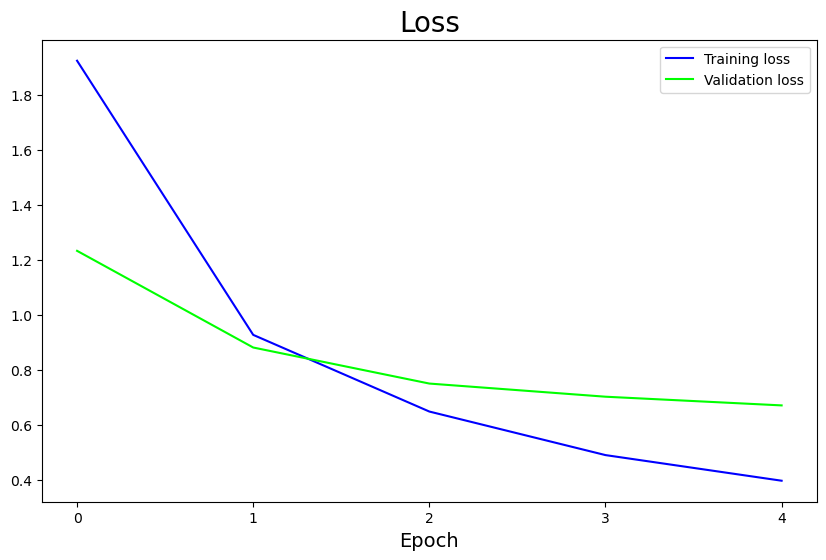

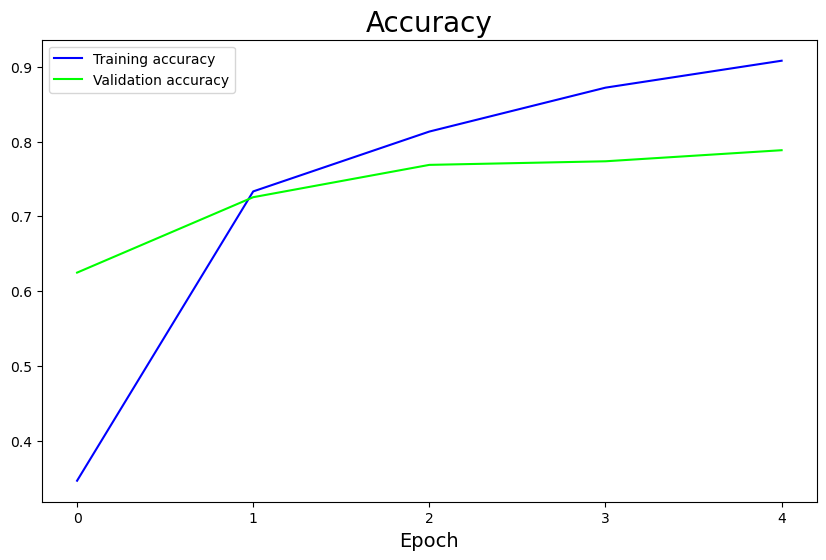

In [12]:
mlp.plot_history(history=resnet_history)

In [34]:
efficientnet_model = create_model(efficientnet_url, num_classes=train_data_10_percent.num_classes)
efficientnet_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [15]:
efficientnet_model.compile(loss=categorical_crossentropy,
                     optimizer=Adam(),
                     metrics=["accuracy"])

In [16]:
cb_tensorboard = mlc.create_tensorboard_callback(experiment_name='efficientnetB0_model_history')

efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[cb_tensorboard])

Saving TensorBoard log files to: ./logs/efficientnet_model_history/20230504-113253
Epoch 1/5
24/24 [==============================] - 15s 376ms/step - loss: 1.8838 - accuracy: 0.4120 - val_loss: 1.2946 - val_accuracy: 0.7340
Epoch 2/5
24/24 [==============================] - 5s 230ms/step - loss: 1.0699 - accuracy: 0.7613 - val_loss: 0.8615 - val_accuracy: 0.8236
Epoch 3/5
24/24 [==============================] - 5s 230ms/step - loss: 0.7619 - accuracy: 0.8413 - val_loss: 0.6934 - val_accuracy: 0.8508
Epoch 4/5
24/24 [==============================] - 6s 244ms/step - loss: 0.6103 - accuracy: 0.8653 - val_loss: 0.6085 - val_accuracy: 0.8580
Epoch 5/5
24/24 [==============================] - 6s 246ms/step - loss: 0.5192 - accuracy: 0.8773 - val_loss: 0.5542 - val_accuracy: 0.8640


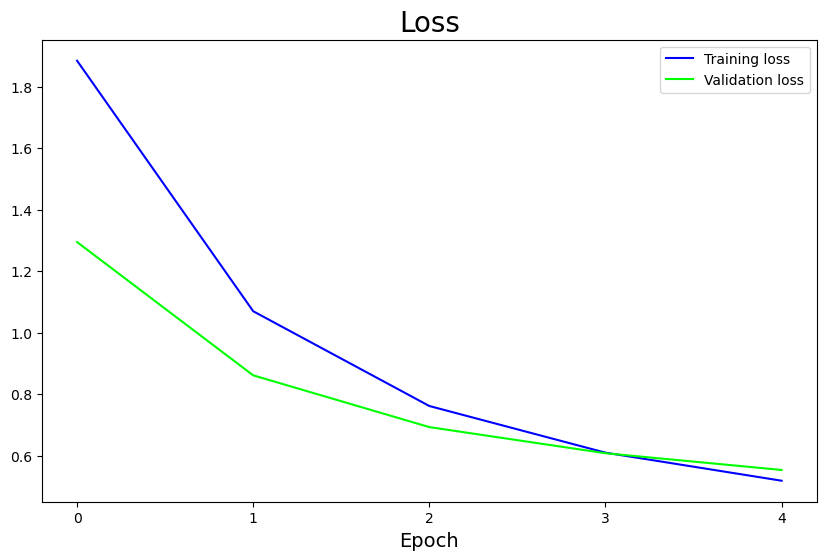

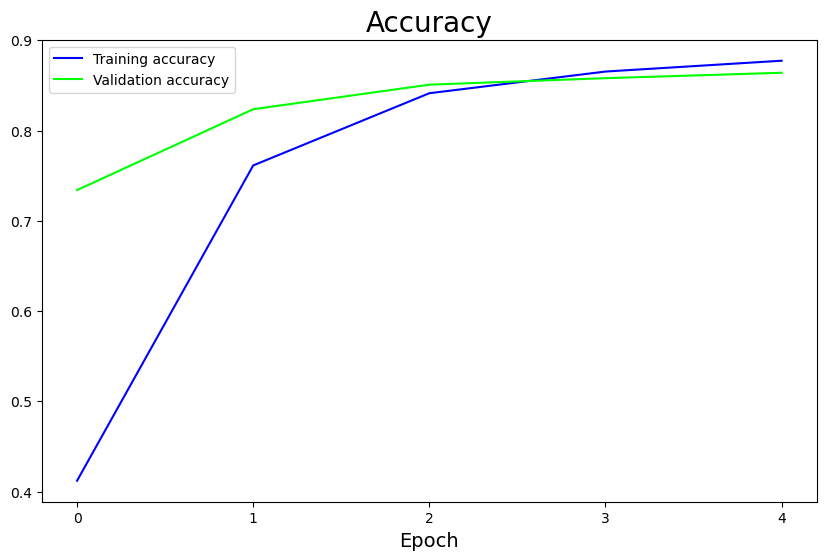

In [17]:
mlp.plot_history(history=efficientnet_history)

In [35]:
len(efficientnet_model.layers[0].weights)

309

In [23]:
efficientnetB4_model = create_model(efficientnetB4_url, num_classes=train_data_10_percent.num_classes)
efficientnetB4_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1792)             17673816  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                17930     
                                                                 
Total params: 17,691,746
Trainable params: 17,930
Non-trainable params: 17,673,816
_________________________________________________________________


In [25]:
efficientnetB4_model.compile(loss=categorical_crossentropy,
                     optimizer=Adam(),
                     metrics=["accuracy"])

In [26]:
cb_tensorboard = mlc.create_tensorboard_callback(experiment_name='efficientnetB4_model_history')

efficientnetB4_history = efficientnetB4_model.fit(train_data_10_percent,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[cb_tensorboard])

Saving TensorBoard log files to: ./logs/efficientnet_model_history/20230504-114455
Epoch 1/5
24/24 [==============================] - 32s 1s/step - loss: 1.7394 - accuracy: 0.4920 - val_loss: 1.1379 - val_accuracy: 0.7716
Epoch 2/5
24/24 [==============================] - 15s 644ms/step - loss: 0.9677 - accuracy: 0.7600 - val_loss: 0.7725 - val_accuracy: 0.8196
Epoch 3/5
24/24 [==============================] - 14s 598ms/step - loss: 0.7112 - accuracy: 0.8147 - val_loss: 0.6409 - val_accuracy: 0.8352
Epoch 4/5
24/24 [==============================] - 14s 582ms/step - loss: 0.5872 - accuracy: 0.8547 - val_loss: 0.5739 - val_accuracy: 0.8480
Epoch 5/5
24/24 [==============================] - 14s 580ms/step - loss: 0.5073 - accuracy: 0.8707 - val_loss: 0.5371 - val_accuracy: 0.8496


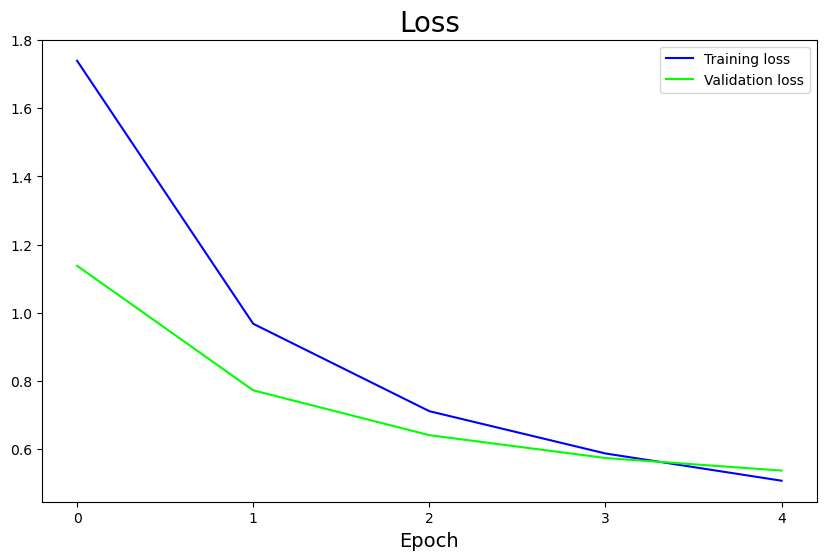

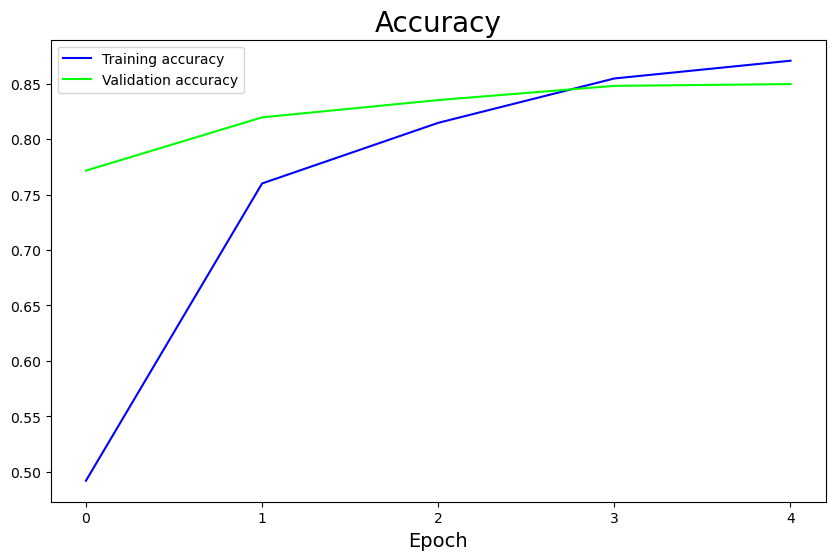

In [27]:
mlp.plot_history(history=efficientnetB4_history)


In [38]:
mobilenet_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5'

In [39]:
mobilenet_model = create_model(mobilenet_url, num_classes=train_data_10_percent.num_classes)
mobilenet_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             2257984   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [41]:
mobilenet_model.compile(loss=categorical_crossentropy,
                     optimizer=Adam(),
                     metrics=["accuracy"])

In [42]:
cb_tensorboard = mlc.create_tensorboard_callback(experiment_name='mobilenetv2_100_224_model_history')

mobilenetv2_100_224_model_history = mobilenet_model.fit(train_data_10_percent,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[cb_tensorboard])

Saving TensorBoard log files to: ./logs/mobilenetv2_100_224_model_history/20230504-124251
Epoch 1/5
24/24 [==============================] - 10s 343ms/step - loss: 1.9843 - accuracy: 0.3173 - val_loss: 1.3274 - val_accuracy: 0.5964
Epoch 2/5
24/24 [==============================] - 5s 204ms/step - loss: 1.0573 - accuracy: 0.7147 - val_loss: 0.8882 - val_accuracy: 0.7484
Epoch 3/5
24/24 [==============================] - 4s 175ms/step - loss: 0.7488 - accuracy: 0.8013 - val_loss: 0.7750 - val_accuracy: 0.7728
Epoch 4/5
24/24 [==============================] - 4s 167ms/step - loss: 0.5881 - accuracy: 0.8360 - val_loss: 0.6839 - val_accuracy: 0.8000
Epoch 5/5
24/24 [==============================] - 4s 177ms/step - loss: 0.4799 - accuracy: 0.8907 - val_loss: 0.6424 - val_accuracy: 0.8032
